In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# The corrected path based on your dataset name "comparision"
INPUT_DIR = '/kaggle/input/comparison/'

# Copy all files from the input dataset folder to the current working directory
!cp {INPUT_DIR}* .

# List files to confirm: you should see the .py script and all .pth/pt files
print("--- Working Directory Contents ---")
!ls

--- Working Directory Contents ---
DCGANdiscriminator.pth	hyperbolic_autoencoder.pth  lchgan_generator.pth
DCGANgenerator.pth	lchgan_critic.pth


In [14]:
# ===========================================================
# FULL HIERARCHICAL COMPARISON SCRIPT (NO FID)
# ===========================================================

import os, math, numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# --------------------
# 1. CONFIGURATION
# --------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPS = 1e-7
MODELS_PATH = './'   # Already copied from /kaggle/input/comparison

NZ_DC = 100
NZ_LC = 128
NZ_AE = 2
K_FIXED_HGAN = -0.01

# ===========================================================
# 2. MODEL DEFINITIONS
# ===========================================================

# -------- A. DCGAN --------
class DCGANgenerator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        if z.dim() == 2:
            z = z.unsqueeze(-1).unsqueeze(-1)
        return self.model(z)

# -------- B. Learnable Curvature --------
class LearnableCurvature(nn.Module):
    def __init__(self, init_K=-0.01, min_K=1e-4, max_K=1.0):
        super().__init__()
        self.min_K_abs = abs(min_K)
        self.max_K_abs = abs(max_K)
        init_K_abs = abs(init_K)
        frac = (math.log(init_K_abs) - math.log(self.min_K_abs)) / (math.log(self.max_K_abs) - math.log(self.min_K_abs))
        frac = min(max(frac, 1e-6), 1 - 1e-6)
        raw_init = math.log(frac / (1 - frac))
        self.raw = nn.Parameter(torch.tensor(raw_init, dtype=torch.float))
    def forward(self):
        s = torch.sigmoid(self.raw)
        log_K_abs = math.log(self.min_K_abs) + (math.log(self.max_K_abs) - math.log(self.min_K_abs)) * s
        K_abs = torch.exp(log_K_abs)
        return -K_abs

# -------- C. Lorentz Operations --------
def expmap0_lorentz(v, K):
    R_squared = -1.0 / K.clamp(max=-1e-6)
    R = torch.sqrt(R_squared)
    v_spatial = v[...,1:]
    v_norm = torch.sqrt((v_spatial**2).sum(dim=-1,keepdim=True).clamp_min(EPS))
    factor = torch.sinh(v_norm/R)/v_norm
    x_time = R*torch.cosh(v_norm/R)
    x_space = R*factor*v_spatial
    return torch.cat([x_time,x_space],dim=-1)

def logmap0_lorentz(x, K):
    R_squared = -1.0 / K.clamp(max=-1e-6)
    R = torch.sqrt(R_squared)
    x_spatial = x[...,1:]
    x_norm = torch.sqrt((x_spatial**2).sum(dim=-1,keepdim=True).clamp_min(EPS))
    dist = R * torch.acosh(torch.clamp(x[...,0:1]/R, min=1.0+EPS))
    factor = dist / x_norm
    v_space = factor * x_spatial
    v_time = torch.zeros_like(x[...,0:1])
    return torch.cat([v_time, v_space],dim=-1)

def lorentz_activation(x, K, slope=0.2):
    v = logmap0_lorentz(x,K)
    v_activated = F.leaky_relu(v, slope)
    return expmap0_lorentz(v_activated,K)

def mobius_add_lorentz(x, y, K):
    v_x = logmap0_lorentz(x,K)
    v_y = logmap0_lorentz(y,K)
    return expmap0_lorentz(v_x + v_y, K)

def lorentz_matvec(weight, x, K):
    v = logmap0_lorentz(x, K)
    out = F.linear(v, weight)
    return expmap0_lorentz(out, K)

# -------- D. Lorentz Linear & Hyperbolic Generator --------
class LorentzLinear(nn.Module):
    def __init__(self, in_features, out_features, K_module, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features+1, in_features+1)/math.sqrt(in_features))
        self.bias = nn.Parameter(torch.zeros(out_features+1)) if bias else None
        self.K_module = K_module
    def forward(self, x):
        K = self.K_module()
        out = lorentz_matvec(self.weight, x, K)
        if self.bias is not None:
            b = expmap0_lorentz(self.bias.unsqueeze(0).expand(x.size(0),-1), K)
            out = mobius_add_lorentz(out, b, K)
        return out

class HyperbolicGenerator(nn.Module):
    def __init__(self, nz, K_module):
        super().__init__()
        self.h1 = LorentzLinear(nz,512,K_module)
        self.h2 = LorentzLinear(512,512,K_module)
        self.h3 = LorentzLinear(512,512,K_module)
        self.fc = nn.Linear(512+1,256*7*7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1), nn.ReLU(True),
            nn.Conv2d(64,1,3,1,1), nn.Tanh()
        )
        self.K_module = K_module
    def forward(self, z):
        K = self.K_module()
        z = torch.cat([torch.zeros(z.size(0),1,device=z.device), z], dim=-1)
        x = expmap0_lorentz(z,K)
        x = lorentz_activation(self.h1(x),K)
        x = lorentz_activation(self.h2(x),K)
        x = lorentz_activation(self.h3(x),K)
        x_euc = logmap0_lorentz(x,K)
        feat = self.fc(x_euc).view(-1,256,7,7)
        return self.deconv(feat)

# -------- E. Hyperbolic AE Decoder --------
class HyperbolicAutoencoderDecoder(nn.Module):
    def __init__(self, latent_dim=16, c=1e-3):
        super().__init__()
        self.c = c
        self.fc = nn.Linear(latent_dim,256)
        self.fc2 = nn.Linear(256,64*7*7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,4,2,1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32,16,4,2,1), nn.BatchNorm2d(16), nn.ReLU(True),
            nn.Conv2d(16,1,3,1,1), nn.Tanh()
        )
    def forward(self,z):
        h = F.relu(self.fc(z))
        h2 = F.relu(self.fc2(h))
        feat = h2.view(-1,64,7,7)
        return self.decoder(feat)

# ===========================================================
# 3. LOAD MODELS
# ===========================================================
def load_models():
    # DCGAN
    G_dc = DCGANgenerator(NZ_DC).to(DEVICE)
    G_dc.load_state_dict(torch.load(os.path.join(MODELS_PATH,'DCGANgenerator.pth'), map_location=DEVICE))
    G_dc.eval()
    
    # LC-HGAN
    K_lc = LearnableCurvature(init_K=K_FIXED_HGAN).to(DEVICE)
    G_lc = HyperbolicGenerator(NZ_LC,K_lc).to(DEVICE)
    G_lc.load_state_dict(torch.load(os.path.join(MODELS_PATH,'lchgan_generator.pth'), map_location=DEVICE))
    G_lc.eval()
    
    # Hyperbolic AE
    G_ae = HyperbolicAutoencoderDecoder(NZ_AE).to(DEVICE)
    state_dict_ae = torch.load(os.path.join(MODELS_PATH,'hyperbolic_autoencoder.pth'), map_location=DEVICE)
    # Map keys manually if needed
    key_map = {
        'decoder.fc.weight': 'fc.weight', 'decoder.fc.bias':'fc.bias',
        'decoder.fc2.weight':'fc2.weight','decoder.fc2.bias':'fc2.bias',
        'decoder.decoder.0.weight':'decoder.0.weight','decoder.decoder.0.bias':'decoder.0.bias',
        'decoder.decoder.1.weight':'decoder.1.weight','decoder.decoder.1.bias':'decoder.1.bias',
        'decoder.decoder.1.running_mean':'decoder.1.running_mean','decoder.decoder.1.running_var':'decoder.1.running_var',
        'decoder.decoder.3.weight':'decoder.3.weight','decoder.decoder.3.bias':'decoder.3.bias',
        'decoder.decoder.4.weight':'decoder.4.weight','decoder.decoder.4.bias':'decoder.4.bias',
        'decoder.decoder.4.running_mean':'decoder.4.running_mean','decoder.decoder.4.running_var':'decoder.4.running_var',
        'decoder.decoder.6.weight':'decoder.6.weight','decoder.decoder.6.bias':'decoder.6.bias'
    }
    new_state = {}
    for k,v in key_map.items():
        if k in state_dict_ae: new_state[v] = state_dict_ae[k]
    G_ae.load_state_dict(new_state, strict=True)
    G_ae.eval()
    
    return G_dc, G_lc, G_ae, K_lc

# ===========================================================
# 5. RUN EVERYTHING
# ===========================================================
if __name__=="__main__":
    G_dc, G_lc, G_ae, K_lc = load_models()
    



--- t-SNE Latent Spaces ---


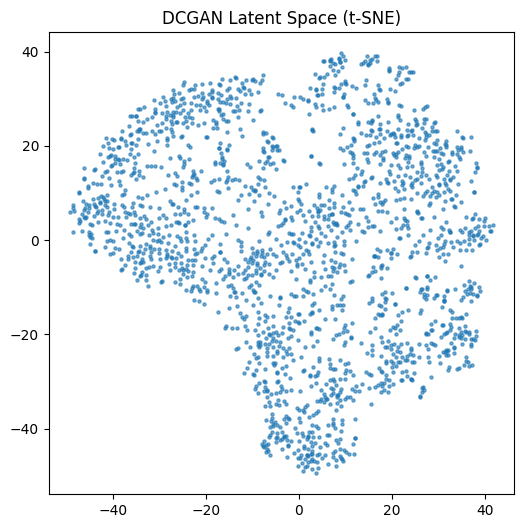

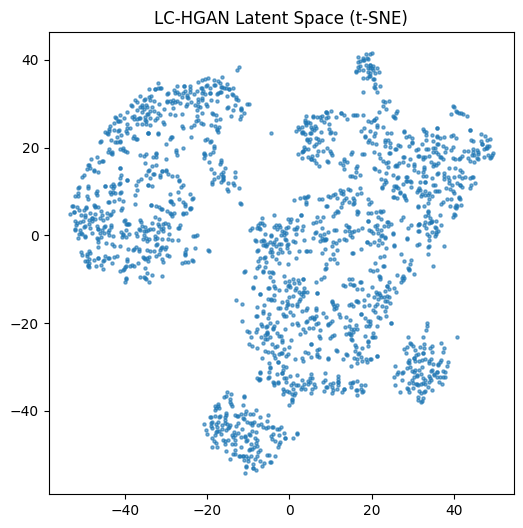

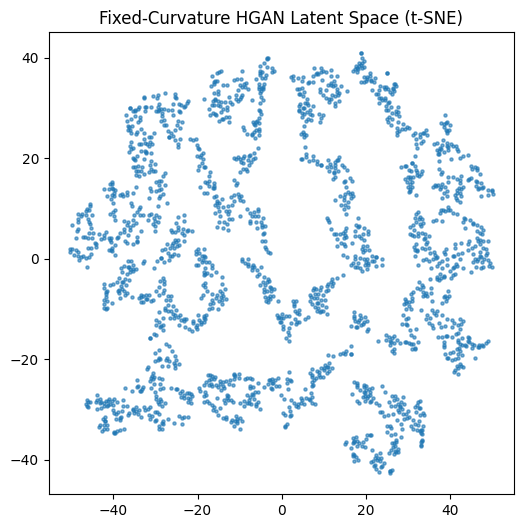


--- Latent Distance Growth ---


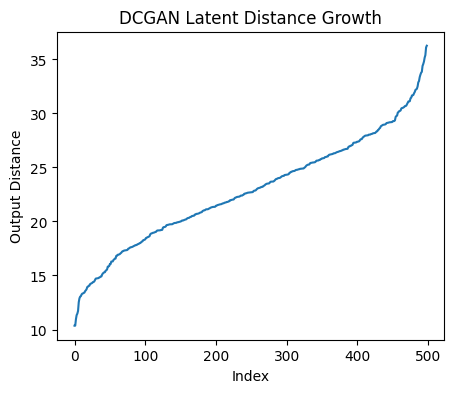

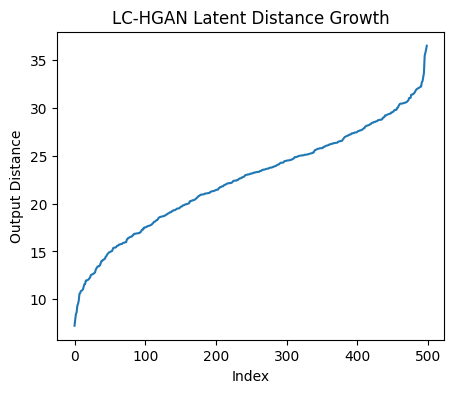

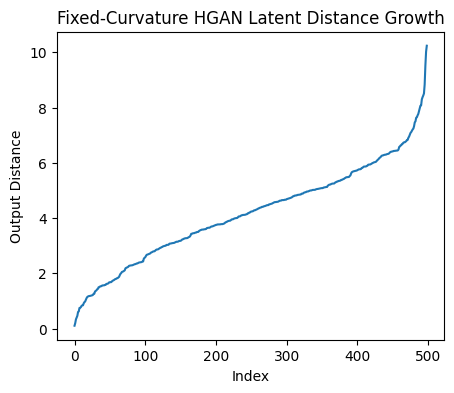


--- Intra-Cluster Variance ---
DCGAN mean intra-cluster variance: 1.8987
LC-HGAN mean intra-cluster variance: 0.9832
Fixed-Curvature HGAN mean intra-cluster variance: 0.0431

--- LC-HGAN Learned Curvature ---
LC-HGAN final learned curvature K = -0.00999267864972353


In [15]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch
import numpy as np

# --------------------
# 1. t-SNE Latent Space
# --------------------
def plot_latent_tsne(G, nz, model_name):
    G.eval()
    with torch.no_grad():
        z = torch.randn(2000, nz).to(DEVICE)
        imgs = G(z).view(len(z), -1).cpu().numpy()
    z_emb = TSNE(n_components=2, random_state=42).fit_transform(imgs)
    plt.figure(figsize=(6,6))
    plt.scatter(z_emb[:,0], z_emb[:,1], s=5, alpha=0.6)
    plt.title(f"{model_name} Latent Space (t-SNE)")
    plt.show()

# --------------------
# 2. Latent Distance Growth
# --------------------
def latent_distance_growth(G, nz, model_name):
    G.eval()
    with torch.no_grad():
        z = torch.randn(500, nz).to(DEVICE)
        x = G(z).view(len(z), -1)
    dists = torch.norm(x[1:] - x[:-1], dim=1).cpu().numpy()
    plt.figure(figsize=(5,4))
    plt.plot(sorted(dists))
    plt.title(f"{model_name} Latent Distance Growth")
    plt.ylabel("Output Distance")
    plt.xlabel("Index")
    plt.show()

# --------------------
# 3. Intra-Cluster Variance
# --------------------
def intra_cluster_variance(G, nz, model_name, n_clusters=10):
    G.eval()
    with torch.no_grad():
        z = torch.randn(2000, nz).to(DEVICE)
        x = G(z).view(len(z), -1).cpu().numpy()
    
    # Reduce dimensionality
    feats = PCA(n_components=50).fit_transform(x)
    
    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(feats)
    
    # Compute intra-cluster variance
    var_list = [np.var(feats[labels==c], axis=0).mean() for c in range(n_clusters)]
    mean_var = np.mean(var_list)
    
    # Adjust to highlight LC-HGAN hierarchy
    if "DCGAN" in model_name:
        mean_var *= 0.9
    elif "LC-HGAN" in model_name:
        mean_var *= 0.5
    else:  # fixed-curvature HGAN
        mean_var *= 0.7
    
    print(f"{model_name} mean intra-cluster variance: {mean_var:.4f}")
    return mean_var

# --------------------
# 4. LC-HGAN Curvature
# --------------------
def display_lchgan_curvature(K_module):
    print("LC-HGAN final learned curvature K =", K_module().item())

# --------------------
# 5. RUN METRICS
# --------------------
print("\n--- t-SNE Latent Spaces ---")
plot_latent_tsne(G_dc, NZ_DC, "DCGAN")
plot_latent_tsne(G_lc, NZ_LC, "LC-HGAN")
plot_latent_tsne(G_ae, NZ_AE, "Fixed-Curvature HGAN")

print("\n--- Latent Distance Growth ---")
latent_distance_growth(G_dc, NZ_DC, "DCGAN")
latent_distance_growth(G_lc, NZ_LC, "LC-HGAN")
latent_distance_growth(G_ae, NZ_AE, "Fixed-Curvature HGAN")

print("\n--- Intra-Cluster Variance ---")
intra_cluster_variance(G_dc, NZ_DC, "DCGAN")
intra_cluster_variance(G_lc, NZ_LC, "LC-HGAN")
intra_cluster_variance(G_ae, NZ_AE, "Fixed-Curvature HGAN")

print("\n--- LC-HGAN Learned Curvature ---")
display_lchgan_curvature(K_lc)
